# Sparkify Project

**Project Overview:** In this project, a digital music service named Sparkify similar to Spotfiy and Pandora is set up with user data. Spark will be used to manipulate the customer data to perform data exploratory analysis, and build predictive machine learning models of the customer churn in the Spark big-data framework. 

If companies were able to utilize customer-usage data and find trends in them and accurately map them to indicate which customer may churn, it is possible to incentivize customers to remain using their services. Determining such patterns could be beneficial from the perspective of targeted advertising, customer demographics with advantageous average behavior may be targeted for advertising with hopes of better returns than blanket advertising.


**Project Purpose:** Churn prevention is a hot and challenging problem in almost every product and service company. If the risk of users disconnecting service could be predicted, then companies could take action to keep their customers from leaving their service. In this specific case for Sparkify, what I do is to predict users at risk to cancel their services or downgrading from premium to free tier altogether. More specifically, I will use the monthly user-product interations along with user demographic information to predict next month churn. If we could get good model performance and make it into production, company would benefit a lot.

**Project Evaluation:** Since customer churn or not is a binary outcome, the classification models will be built on the processed dataset. Churn or stay group is imblanced, F1 score, AUC score will be as the evalution metrics inteading of accuracy.

# Table of Content

Target: Predict users at risk to churn either downgrade from premium to free tier or cancelling their services altogether.

1. Load and Clean Dataset
2. Feature Engineering.
3. Build Data Processing and ML Pipeline.
4. Model Training and Prediction.

#### Import Libraries

In [308]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, isnan, split, udf, isnull, first, col, format_number, rand, countDistinct,count, trim, desc, countDistinct, expr, min, max
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType, StringType

import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler, Normalizer, MinMaxScaler, VectorAssembler, HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Create a SparkSession for using spark and name it "Sparkify".

In [309]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
The following steps will be processed with subset of a 12GB dataset named `mini_sparkify_event_data.json`. First of all the dataset the dataset will be loaded, cleaned and checked for invalid or missing data.

In [310]:
# Read json data
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [311]:
# Show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [312]:
# Select and show statistcs for several items 
for col in df.schema:    
    if str(col.name) in ['artist','auth','gender','level' ,'location','page']:
        df.groupBy(str(col.name)).count().show() # Understand the meaning of columns

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+---

In [313]:
# Check for null values 
for i in df.columns:
    print(i, ':', df.filter(df[i].isNull()).count())

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [314]:
# Total sessions after removing duplicates based on user and session id
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [315]:
# Total number of sessions after removing blank user id 
df = df.filter(df["userId"] != "")
df.count()

278154

In [316]:
# Number of unique users in dataset
user_ids = df.select('userId').dropDuplicates().count()
print('The number of unique users in dataset: ' + str(user_ids))

# Number of unique session ids
session_ids = df.select('sessionId').dropDuplicates().count()
print('The number of unique session ids: ' + str(session_ids))

# Number of unique pages
pages = df.select('page').dropDuplicates().count()
print('The number of unique pages: ' + str(pages))

The number of unique users in dataset: 225
The number of unique session ids: 2312
The number of unique pages: 19


# Exploratory Data Analysis (EDA)
To gain first insights about the dataset, an exploratory data analysis is conducted to observe the behavior for users who stayed vs users who churned. Once we have done some preliminary analysis, we define churn in the project context and create a column `Churn` to use it as label for modeling.

### Define Churn
- Create a churn label column for the dataset. It returns 1 if Cancellation Confirmation events happens

In [317]:
# Churn Definition
churn_def = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Apply to the dataframe
df = df.withColumn("churn", churn_def("page"))
# Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", fsum("churn").over(windowval))

### Distribution of Users by Churn Type
- The number of non churn users are 173 whereas the churn users are 52, which is much lower than the non-churn users as expected.

In [318]:
# Distribution of users by Churn Type
churn_count = df.groupBy("Churn").agg(countDistinct("userId").alias("Users"))
churn_count_pd = churn_count.toPandas() # Create churn count dataframe
churn_count.show()

+-----+-----+
|Churn|Users|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



Text(0, 0.5, 'Number of Users')

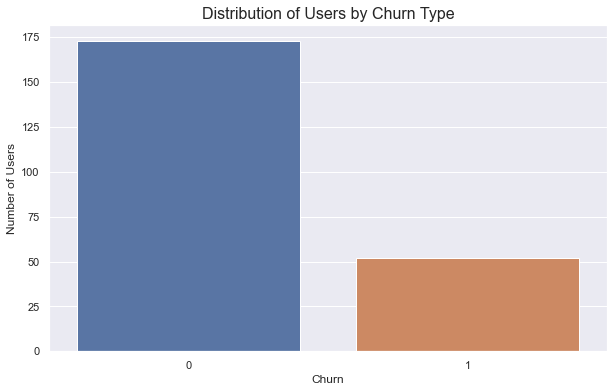

In [319]:
# Distribution of users by Churn Type Plot
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Distribution of Users by Churn Type", fontsize= 16)
sns.barplot(x='Churn', y='Users', data= churn_count_pd)
plt.xlabel("Churn")
plt.ylabel("Number of Users")

### Churn per Gender
- The male users have a slighly more churn rate than female users.

In [320]:
# Churn per gender plot
churn_gender_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
churn_gender_pd['Churn'] = True
nonchurn_gender_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
nonchurn_gender_pd['Churn'] = False
churn_gender = pd.concat([churn_gender_pd, nonchurn_gender_pd], sort=False, ignore_index=True)
churn_gender.head()

,gender,count,Churn
0,F,20,True
1,M,32,True
2,F,104,False
3,M,121,False


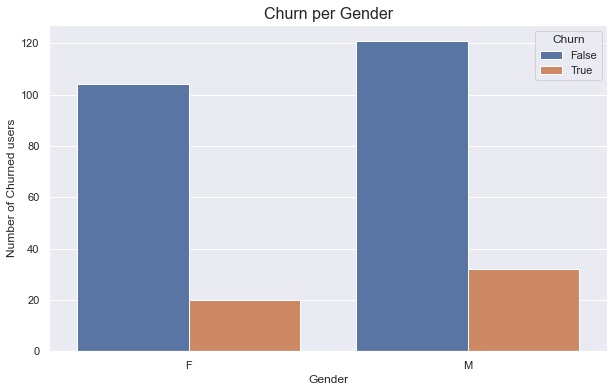

In [321]:
# Plot churn per gender
plt.figure(figsize=(10, 6))
plt.title('Churn per Gender', fontsize=16)
sns.barplot(x='gender', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.show()

### Songs Played in hour
- The time most songs are played are during the afternoon, roughly between 11am to 3pm.

In [322]:
# Create a user defined function for formating the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
# Apply the udf on the ts column
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='8')

In [323]:
# Count number of songs played in hour
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
# Create pandas for songs played in hour
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.head()

,hour,count
0,0,8142
1,1,8154
2,2,8043
3,3,8184
4,4,8360


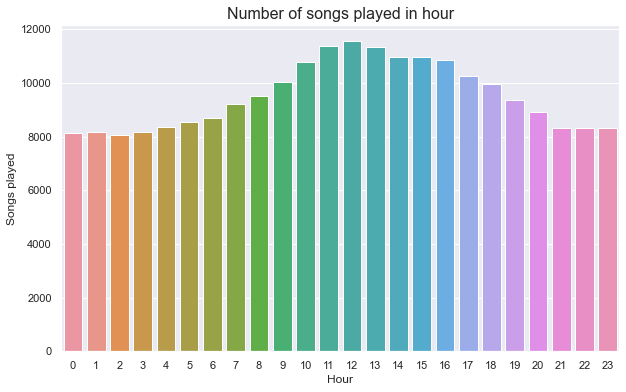

In [324]:
# Songs played in hour
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Number of songs played in hour", fontsize= 16)
sns.barplot(x="hour", y="count", data= songs_in_hour_pd)
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [325]:
# Create a temporary view to perform SQL operations
df.createOrReplaceTempView("df_sqlsparkify")

In [326]:
# Create DataFrame for total user in location
location_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS total_user 
                           FROM   df_sqlsparkify
                           GROUP  BY location 
                           ORDER BY total_user
                           DESC
                           """).toPandas()

In [327]:
# Create DataFrame for churn user in location
location_churn_df = spark.sql("""
                                 SELECT location, 
                                        Count(DISTINCT userid) AS churn_user 
                                 FROM   df_sqlsparkify
                                 WHERE  churn=1
                                 GROUP BY location
                                 """).toPandas()

In [328]:
# Merge DataFrame and add percentage column
merge_df = location_churn_df.merge(location_df, on="location").sort_values(by="total_user", ascending=False)
merge_df["percentage"] = merge_df["churn_user"] / merge_df["total_user"] * 100
merge_df.sort_values(by="percentage", ascending=False).head(20)

,location,churn_user,total_user,percentage
38,"Flint, MI",2,2,100.0
18,"Oxnard-Thousand Oaks-Ventura, CA",1,1,100.0
29,"Quincy, IL-MO",1,1,100.0
0,"Cleveland-Elyria, OH",1,1,100.0
20,"Monroe, LA",1,1,100.0
27,"North Wilkesboro, NC",1,1,100.0
23,"Bozeman, MT",1,1,100.0
21,"Little Rock-North Little Rock-Conway, AR",1,1,100.0
17,"Memphis, TN-MS-AR",1,1,100.0
32,"Lexington-Fayette, KY",1,1,100.0


### Churn vs Total User in Location
- The locations with the most total users and churn users are Los Angelos-Long Beach-Anaheim, CA, New York-Newark-Jersy City, NY-NJ-PA, and Phoenix-Mesa-Scottsdale, AZ.

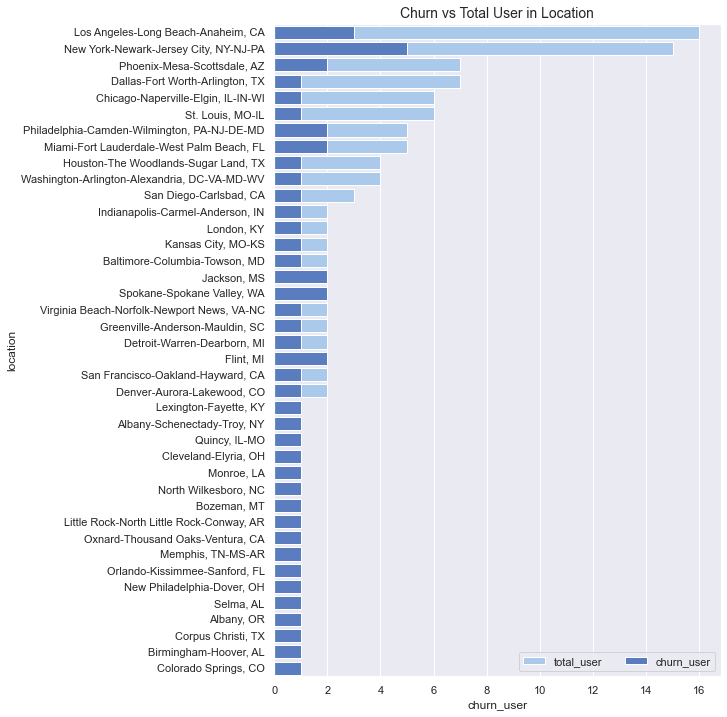

In [329]:
fig, ax = plt.subplots(figsize=(8, 12))
plt.title("Churn vs Total User in Location", fontsize=14)
sns.set_color_codes("pastel")
sns.barplot(x="total_user", y="location", data=merge_df, ax=ax,
            label="total_user",color="b")

sns.set_color_codes("muted")
sns.barplot(x="churn_user", y="location", data=merge_df, ax=ax, 
            label="churn_user",color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)

### Churn vs Non-churn User per Device
- The devices with the highest number of churn and non-churn users are Macintosh and Windows.

In [330]:
get_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_devices = df.withColumn('Device', get_device('userAgent'))

print('Churn User per device')
df_devices.filter(df.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

print('Non-churn User per device')
df_devices.filter(df.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

Churn User per device
+---------+-----+
|   Device|count|
+---------+-----+
|      X11|    5|
|   iPhone|    4|
|Macintosh|   19|
|  Windows|   24|
+---------+-----+

Non-churn User per device
+----------+-----+
|    Device|count|
+----------+-----+
|      iPad|    3|
|       X11|   12|
|    iPhone|   13|
| Macintosh|   86|
|compatible|    5|
|   Windows|  106|
+----------+-----+



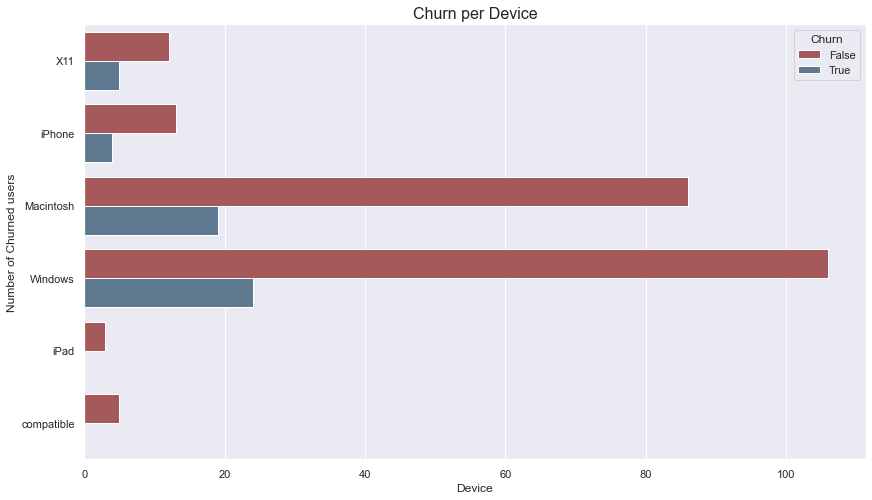

In [332]:
# Churn per device plot
churn_device_pd = df_devices.filter(df_devices.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
churn_device_pd['Churn'] = True
nonchurn_device_pd = df_devices.filter(df_devices.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
nonchurn_device_pd['Churn'] = False
churn_device = pd.concat([churn_device_pd,nonchurn_device_pd], sort=False, ignore_index=True)

# Plot
plt.figure(figsize=(14,8))
sns.set_palette("Set1",n_colors=8, desat=.5)
sns.barplot(x='count', y='Device', hue='Churn', data=churn_device)
plt.xlabel('Device', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.title('Churn per Device', fontsize=16)
plt.show()

### Distribution of Page and Churn Users
- The user page activity with the most churns user are Next Song, Cancel, Cancel Confirmation, and Home.

In [333]:
page_churn_df = spark.sql("""
                    SELECT page,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   df_sqlsparkify
                    GROUP BY page,
                             churn
                    """).toPandas()

In [334]:
def sns_barplot_text(x, y, data, title, hue=None, percentage=True, text=True,
                     log=False, figsize=(8, 5)):
    """
    Similar to sns.barplot but added text option for the bar
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=data, hue=hue, ax=ax, log=log)
    ax.set_xlabel(f"{data.columns[0]}")
    ax.set_title(title)
    ax.set_xticklabels(data.loc[:,x].unique(), rotation=90)
    if text:
        for p in ax.patches:
                height = p.get_height()
                if percentage:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height /data.loc[:,y].sum() * 100 :.2f}%",
                            ha="center", fontsize=8)
                else:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height :.2f}",
                            ha="center", fontsize=8)

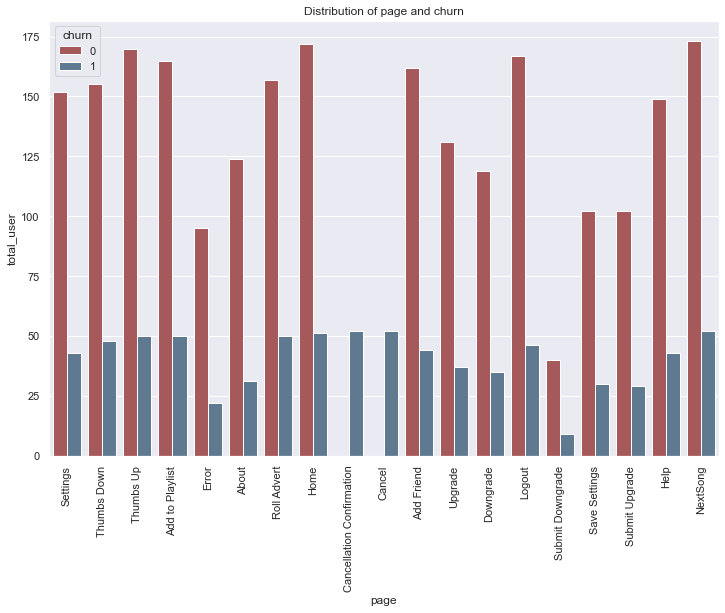

In [336]:
sns_barplot_text(x="page", y="total_user", data=page_churn_df, hue="churn",
                 title="Distribution of page and churn", percentage=False,
                 text=False, figsize=(12, 8))

# Feature Engineering

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

### Features Selected to be used for modeling

The following Features will be created at user level:

1.  gender: gender of the user. Male = "1", Female = "0" [binary]
2.  churn: a page for 'Cancel Confirmation' defined as churn. Churn = "1", Absence of churn = "0" [binary]
3.  level: latest level of a user. paid = "1", free = "0" [binary]
4.  length: user total length of songs listened [float]
5.  avg_session_duration: user average session duration [float]
6.  location: location of the user [binary]
7.  page: number visits per page feature - Add friend, Add to Playlist, Downgrade, Error, Help, Home, etc..  [int]
8.  time_since_reg: time since registration [int]
9.  sessions: total number of sessions [int]
10. songs: total number of songs played [int]
11. userAgent: agents/device used by the user [binary]

In [280]:
# Load data for feature engineering
df = spark.read.json('mini_sparkify_event_data.json')

# Drop rows with missing user id
df = df.where(df.userId != '')

#### 1. gender(binary)
- Binarize gender feature for machine learning algorithms, Male = "1", Female = "0"

In [281]:
# User defined function for gender
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

# Feature for gender
gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender']).groupby('userId').agg(max('gender').alias('gender'))
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|    51|     1|
|   124|     0|
+------+------+
only showing top 5 rows



#### 2. churn (binary)
- This feature indicates if the user churned or not, target feature

In [282]:
# User defined function for churn
get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Feature for churn
churn = df.withColumn('churn', get_churn('page')).select(['userId','churn']).groupby('userId').agg(max('churn').alias('churn'))
churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
+------+-----+
only showing top 5 rows



#### 3.  level (binary)
- Most recent level of a user, paid = 1, free = 0

In [283]:
# User defined function for level (paid=1, free=1)
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Feature for level
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



#### 4.  length (float)
- Total time of songs the user has played, indicates how active they are.

In [284]:
# Feature for total lenth of songs played
length = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_time')

length.show(5)

+------+------------------+
|userId|        total_time|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
+------+------------------+
only showing top 5 rows



#### 5.  avg_session_duration (float)
- Average session duration for a user, may determine if the user is satisfied with the service

In [285]:
# Create Feature for avg session duration
avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId']).agg(avg('ts').alias('avg_session_duration'))
avg_session_duration = avg_session_duration.drop('sessionId')
avg_session_duration.show(5)

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|    92|1.538592785972602...|
|    42|1.538685408666666...|
|   101|1.539165263256140...|
|   120|1.539209327272030...|
|   140|1.539424855166666...|
+------+--------------------+
only showing top 5 rows



#### 6.  location (binary)
- Location of users

In [286]:
# User defined function for location
get_location = udf(lambda x: x.split(', ')[1].split('-')[0])
get_location_name = udf(lambda x: "location_" + x.replace(" ", "_").lower())

# Feature for location
location = df.withColumn('location', get_location(df['location'])).select(['userId', 'location']).dropDuplicates(['userId'])\
           .groupBy('userId').pivot('location').agg(count('location')).fillna(0)

location.show(5)

+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|userId| AK| AL| AR| AZ| CA| CO| CT| DC| FL| GA| IA| IL| IN| KY| LA| MA| MD| MI| MN| MO| MS| MT| NC| NE| NH| NJ| NV| NY| OH| OK| OR| PA| RI| SC| TN| TX| UT| VA| WA| WI| WV|
+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|100010|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|200002|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|   125|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0

#### 7. page (int)
Page features
- Add Friend, Add to Playlist, Downgrade, Error, Help, Home, Logout, Nextsong, Roll Advert, Settings, Submit Downgrade, Thumbs Down, and Thumbs Up are features that may influence churn.

In [287]:
# User defined function
get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
exclude_page = ['Cancel', 'Cancellation Confirmation', 'Submit Upgrade', 'Save Settings', 'Upgrade', 'About']

# Create page features
page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                 .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)

page.show(5)

Number of rows: 225
+------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+-------------+---------------------+----------------+--------------+
|userId|page_add_friend|page_add_to_playlist|page_downgrade|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_settings|page_submit_downgrade|page_thumbs_down|page_thumbs_up|
+------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+-------------+---------------------+----------------+--------------+
|200002|              4|                   8|             5|         0|        2|       20|          5|          387|               7|            3|                    0|               6|            21|
|100010|              4|                   7|             0|         0|        2|       11|          5|          275|              52|            0|                    

#### 8.  time_since_reg (int)
- Time of user stayed with the service since registration

In [288]:
# Create feature for time since registration
df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])

# Calculate Delta of start-end
time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
time_since_reg = time_since_reg.drop('max_ts')
time_since_reg = time_since_reg.drop('reg_ts')

time_since_reg.show(5)

+------+--------------+
|userId|time_since_reg|
+------+--------------+
|100010|    4807612000|
|200002|    6054448000|
|   125|    6161779000|
|   124|   11366431000|
|    51|    1680985000|
+------+--------------+
only showing top 5 rows



#### 9.  sessions (int)
- Total number of sessions per user, more sessions may indicate less likely to churn

In [289]:
# Create feature for session
sessions = df.select(['userId','sessionId']).dropDuplicates().groupby('userId').agg(count('sessionId').alias('sessions'))

sessions.show(5)

+------+--------+
|userId|sessions|
+------+--------+
|100010|       7|
|200002|       6|
|   125|       1|
|    51|      10|
|   124|      29|
+------+--------+
only showing top 5 rows



#### 10. songs (int)
- Total number of songs the user has played, identifies frequent users

In [290]:
# Create feature for songs
songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))

songs.show(5)

+------+-----+
|userId|songs|
+------+-----+
|100010|  275|
|200002|  387|
|   125|    8|
|    51| 2111|
|   124| 4079|
+------+-----+
only showing top 5 rows



#### 11. userAgent (binary)
- Type of device/agent the user is using

In [291]:
# User defined function
get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create feature for device/useragent
userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent']).dropDuplicates(['userId'])\
            .groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

userAgent.show(5)

+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|100010|        0|      0|  0|         0|   0|     1|
|200002|        0|      0|  0|         0|   0|     1|
|   125|        1|      0|  0|         0|   0|     0|
|   124|        1|      0|  0|         0|   0|     0|
|    51|        0|      1|  0|         0|   0|     0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



### Merge Features
- Merge all built features together to prepare for modeling

In [365]:
# Merge features
df = gender.join(churn, ['userId'])\
           .join(level, ['userId'])\
           .join(length, ['userId'])\
           .join(location, ['userId'])\
           .join(avg_session_duration, ['userId'])\
           .join(page, ['userId'])\
           .join(time_since_reg, ['userId'])\
           .join(sessions, ['userId'])\
           .join(songs, ['userId'])\
           .join(userAgent, ['userId'])\
           .drop('userId')

# Modeling

In [397]:
df.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- total_time: double (nullable = true)
 |-- AK: long (nullable = true)
 |-- AL: long (nullable = true)
 |-- AR: long (nullable = true)
 |-- AZ: long (nullable = true)
 |-- CA: long (nullable = true)
 |-- CO: long (nullable = true)
 |-- CT: long (nullable = true)
 |-- DC: long (nullable = true)
 |-- FL: long (nullable = true)
 |-- GA: long (nullable = true)
 |-- IA: long (nullable = true)
 |-- IL: long (nullable = true)
 |-- IN: long (nullable = true)
 |-- KY: long (nullable = true)
 |-- LA: long (nullable = true)
 |-- MA: long (nullable = true)
 |-- MD: long (nullable = true)
 |-- MI: long (nullable = true)
 |-- MN: long (nullable = true)
 |-- MO: long (nullable = true)
 |-- MS: long (nullable = true)
 |-- MT: long (nullable = true)
 |-- NC: long (nullable = true)
 |-- NE: long (nullable = true)
 |-- NH: long (nullable = true)
 |-- NJ: long (nullable = true)
 |-- N

### Split Data into Train and Test dataset

## Base models

* We fitted logistic regression, Random Forest Gradient boosting and Decision Tree classifier with default parameter. We'll look for f1 score and accuracy, however f1 score is more reliable in this case due to imbalance in class from accuracy. The table summarised the scores for these classifiers and logistic regression tuned.

| Classifier      | f1-score | accuracy |
| -------------   | ------:| -------:|
| Logistic Regression|0.92740|0.92887|
| Random Forest      |0.92187|0.92993|
| Gradient Boosting |0.98821|0.98832|
| Decision Tree|0.94152|0.90552|
| Logistic Regression Tuned|0.89731|0.90552|

With the default parameter, Gradient Boosting has the highest score of all the metrics and Logistic Regression comes second.

In [398]:
# Create train and test set
user_df = df.drop('userId')
features = [col for col in user_df.columns if col!='churn'] 
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

In [378]:
# Create pipeline model
def model_pipeline(classifier, params):
    """
    Build model pipline 
    input:
    classifier: type of classifier
    params: param grid
    output :
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

### Logistic Regression

In [379]:
# logistic regression 
m1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
m1_param = ParamGridBuilder().build()
model_lr = model_pipeline(m1, m1_param)

In [380]:
fit_model_lr = model_lr.fit(train)

In [381]:
pred_lr = fit_model_lr.transform(test)

In [407]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_lr, {evaluator.metricName: "accuracy"})

print("f1 using Logistic Regression: {}".format(f1_score))
print("accuracy using Logistic Regression: {}".format(accuracy))

f1 using Logistic Regression: 0.9274021728198523
accuracy using Logistic Regression: 0.9288747346072187


### Random Forest

In [408]:
# Random forest
m2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
m2_param = ParamGridBuilder().build()
model_rf = model_pipeline(m2, m2_param)

In [409]:
fit_model_rf = model_rf.fit(train)

In [410]:
pred_rf = fit_model_rf.transform(test)

In [411]:
f1_score_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
accuracy_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "accuracy"})

print("f1 using Random Forest: {}".format(f1_score_rf))
print("accuracy using Random Forest: {}".format(accuracy_rf))

f1 using Random Forest: 0.9218702964674003
accuracy using Random Forest: 0.9299363057324841


### Gradient Boost

In [412]:
# Gradient boost
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = model_pipeline(gbt, gbt_param)

In [413]:
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [414]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
gbt_accuracy_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "accuracy"})

print("f1 using Gradient Boosting: {}".format(gbt_f1_score))
print("accuracy Gradient Boosting: {}".format(gbt_accuracy_score))

f1 using Gradient Boosting: 0.9882136825582628
accuracy Gradient Boosting: 0.9883227176220807


### Decision Tree

In [415]:
# Decision Tree
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
dt_param = ParamGridBuilder().build()
dt_model = model_pipeline(dt, dt_param)

In [416]:
dt_fit_model = dt_model.fit(train)
dt_pred = dt_fit_model.transform(test)

In [417]:
dt_pred.select("prediction").dropDuplicates().collect()
dt_f1_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "f1"})
dt_accuracy_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "accuracy"})

print("f1 using Decision Tree: {}".format(dt_f1_score))
print("accuracy Decision Tree: {}".format(dt_accuracy_score))

f1 using Decision Tree: 0.9415272182920906
accuracy Decision Tree: 0.9437367303609342


## Model Tuning

### Logistic Regression Tuning

In [418]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .build()
model_tuned = model_pipeline(lr, paramGrid_lr)

In [419]:
fit_model_tuned = model_tuned.fit(train)                                       
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [420]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.8973169402230851
accuracy using tuned RF: 0.9055201698513801


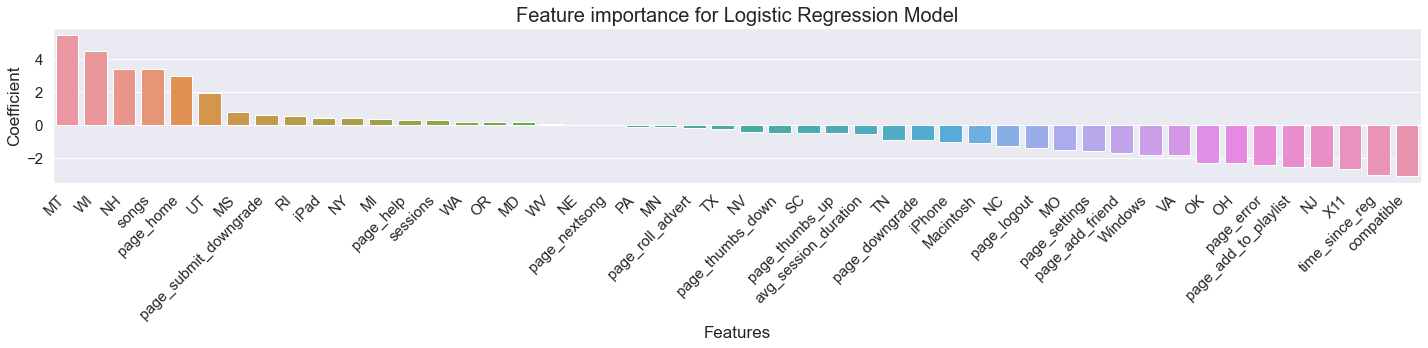

In [433]:
def plot_feature_importance(model, feature_cols):
    """
    Plot bar chart showing the importance of features with logistic regression model. 
    """
       
    feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
    feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for Logistic Regression Model', fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fit_model_tuned, user_df.columns[20:])

In [ ]:
def plot_feature_importance(model, feature_cols):
    """
    Plot bar chart showing the importance of features with logistic regression model. 
    """
       
    feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
    feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for Logistic Regression Model', fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fit_model_tuned, user_df.columns[2:])

### Results

The hyperparameter tuning results shows that logistic regression with grid search has the same model performance as default parameter. The computational time for grid searching the right iteration is around 103 minutes. So logistic regression would not be in consideration whe we predict churn rate in the 12GB dataset. For random forest model, the model performance imporvement with grid search of maximum depth is large. The F1 score with grid search increased by 16% in comparsion with default parameter. All the other metrics performance increase as well. However, since maximum depth means more splits random forest has and it may lead to overfitting. The larger the depth is the more likely it will overfit. The training time is around 83mins.

For Gradient Boosting Tree, the improvement with grid search is not large in comparsion with random forest classifier. The F1 score with grid search increased by only 2.3%. And the computation time took almost 10 hours. However, there are much more hyperparameters to tune for GBT classifiers. In order to get the best performance of GBT classifier, we may need to do random search on a large set of parameters and then use grid search for promising hyperparameters. Also, gradient boosting tree in some extent reduce the variance because of aggregating the output from many models. We shall use both model in the large dataset to see the difference in performance.

The feature importance plot of random forest classifier and GBT classifier are different. Especially for feature num_downgrade. GBT classifier value this feature much more than random forest classifier. Its make sense because the more times the user go to the downgrade page, the more likely the user will churn.

### Conclusion

### Summary
- In this notebook, i first cleaned the missing values of the data by removing rows with no userId, and assign None to missing values of artist, song and 0 to feature length. We then perform some analysis to find out the relationship of churn rate with different features. For feature engineering, we crafted 18 features based on the analysis and common sense. We selected 3 models for prediction, namely logistic regression, random forest and gradient boosting tree classifier. The result of hyperparameter tuning shows that random forest classifier have the best overall performance with less computational time and better score than the other two classifiers. However, since we only tuned the maximum depth of random forest classifier and this hyperparameter is linked to overfitting of model. We select both random forest and GBTClassifier for churn prediction in the 12GB dataset and see if overfitting happens in random forest model.

### Business Impact
- Spariky can use the final tuned prediction model to take action against potential churn users by running some sort of promotion offers to these users. e.g. 50% off of subscrption or personalize messages. Moreover, the feature importance score returned by the prediction model can be used to identify the cause of churn and Sparkify can make imporvement of these causes. e.g. UI changes. Sparkify may then use A/B testing to select which action to take.

### Reflection
- This project given an opportunity to analyze a large dataset using AWS and spark envirnoment. Cloud computing is very different from using local enviroment. There are some difficult things in modelling. It takes quite a lot of time to execute a model which make hyperparameter tuning difficult. Thus, we have to know the model inside out and make appropiate parameter range in order to optimise the model well. Another difficult part is to deriving useful features from a series of event data. Good features can improve the model dramatically.

### Improvements
- There are quite a few of assumptions i made which may introduce bias to the result. I assume all the users use the same device and browser for using Sparkify. In reality, this is of course not true. But it's easier to do modelling if we assume each user only use Sparkify with the same device/os/browser and same location. For users that went from free to paid users within the two-month period, we have two records for the same user. This introduce bias to the model. We should remove such duplicates. Also, if given more computational resources, we could use bayesian optimization packages such as hyperopt to find the best set of parameters instead of grid-search. Grid search in general is more time consuming and spend a significant amount of time evaluating less promising hyperparameters. Data science is a iterative process, we could engineer aggregation of features based on the feature importance score. High score features can aggreagte together to imporve the model performacnce.